# Aplicaciones a Problemas Inversos

**Por:** David Ortiz, Rodrigo Salas

**Edición:** David Ortiz, Tabita Catalán, Tomás Banduc

Paper interesante sobre [estimación de parámetros](https://arxiv.org/abs/2308.00927) en problemas de flujo sanguíneo.

## Introducción

Basándonos en nuestro trabajo previo con PINNs para resolver problemas directos en modelos no lineales y lineales, esta actividad explora el uso de PINNs para problemas inversos. Específicamente, aplicaremos una PINN para estimar parámetros desconocidos en un modelo de difusión, como el coeficiente de difusión $\kappa$, a través de observaciones ruidosas.

## Resumen

En esta actividad, programaremos una PINN para estimar el coeficiente de difusión del modelo lineal de calor en 1D.

## Objetivos

Al término de esta actividad, será capaz de:

 - Usar el método de PINN para resolver problemas inversos.
 - Entrenar una PINN para resolver simultáneamente la ecuación de difusión y estimar el parámetro desconocido del modelo.

## Descripción Matemática del Problema

Al igual que en la Actividad 2, consideraremos el modelo de difusión unidimensional:
$$
\begin{alignat*}{3}
    \text{EDP:} \quad & \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)), \quad && x \in [-1, 1], \quad t \in [0, 2], \quad \kappa\in\mathbb{R}\\
    \text{Solución:} \quad & u(t,x) &&= e^{-t} \sin(\pi x)
\end{alignat*}
$$

donde $u(t,x)$ representa una cantidad física de interés en la posición $x \in [-1,1]$ y en el tiempo $t \in [0,2]$. $\kappa$ es el coeficiente de difusión que buscaremos estimar. En este caso, consideraremos $\kappa=1$ como la solución que deseamos estimar. El principal objetivo es tratar $\kappa$ como un parámetro libre durante el entrenamiento, permitiendo a la red simultáneamente resolver la EDP e inferir el valor de dicho coeficiente.

Para este problema inverso, no necesitamos condiciones iniciales o de borde, sino que nos basamos de información adicional dada por observaciones con ruido $u_{data}(t,x)$ de la solución analítica.

<img src="/home/ihealth/Dropbox/Trabajo/Presentaciones/2023-2025/20251112 Escuela andina sistemas complejos/uta-escuela-sistemas-complejos/data/figures/pinns_new_scheme.png" width="800" height="400">

## Flujo de Trabajo

1. Obtener observaciones con ruido de la solución analítica del problema de valor inicial de la ecuación del calor.
2. Muestrear el dominio para entrenar la PINN.
3. Entrenar la PINN para resolver simultáneamente la ecuación de difusión y estimar el parámetro desconocido.

### Configuración Inicial

Comenzamos importando módulos y definiendo algunas funciones de utilidad

In [2]:
%matplotlib inline
#%matplotlib widget

In [3]:
# NumPy para operaciones numéricas
import numpy as np
# PyTorch para construir y entrenar redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
# Matplotlib para graficar
import matplotlib.pyplot as plt
import matplotlib as mlp
# Time para medir tiempo de entrenamiento
import time
# Warnings para ignorar mensajes de advertencia
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Actualización de los parámetros de Matplotlib
gray = '#5c5c5c' #'#5c5c5c' '000'
mlp.rcParams.update(
    {
        "image.cmap" : 'viridis', # plasma, inferno, magma, cividis
        "text.color" : gray,
        "xtick.color" :gray,
        "ytick.color" :gray,
        "axes.labelcolor" : gray,
        "axes.edgecolor" :gray,
        "axes.spines.right" : False,
        "axes.spines.top" : False,
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,

        'font.size' : 16,
        'interactive': False,
        "font.family": 'sans-serif',
        "legend.loc" : 'best',
        'text.usetex': False,
        'mathtext.fontset': 'stix',
    }
)

# Definir pi en torch
torch.pi = torch.acos(torch.zeros(1)).item() * 2

# Error l2 relativo
def relative_l2_error(u_num, u_ref):
    # Calcular norma l2 de diferencia
    l2_diff = torch.norm(u_num - u_ref, p=2)

    # Calcular norma l2 de referencia
    l2_ref = torch.norm(u_ref, p=2)

    # Calcular norma l2 relativa
    relative_l2 = l2_diff / l2_ref
    return relative_l2

# Función para graficar soluciones
def plot_comparison(u_true, u_pred, loss, k_evol):

    # Convertir tensores de numpy a arreglos, para graficar
    u_pred_np = u_pred.detach().numpy()

    # Crear figura con 2 subplots
    fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Graficar solución analítica
    im1 = axs[0].imshow(u_true, extent=[-1,1,1,0])
    axs[0].set_title('Analytic solution for diffusion')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$t$')
    fig1.colorbar(im1, spacing='proportional',
                            shrink=0.5, ax=axs[0])

    # Graficar predicción
    im2 = axs[1].imshow(u_pred_np, extent=[-1,1,1,0])
    axs[1].set_title('PINN solution for diffusion')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$t$')
    fig1.colorbar(im2, spacing='proportional',
                            shrink=0.5, ax=axs[1])
    # Display de gráfico
    plt.tight_layout()
    plt.show()


    # Graficar los valores de la pérdida guardados durante el entrenamiento
    # Crear figura con 2 subplots
    fig2, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Graficar evolución de parámetro de difusión kappa
    axs[0].plot(k_evol, label="PINN estimate")
    axs[0].hlines(1, 0, len(k_evol), label="True value", color="tab:green")
    axs[0].set_title(r"$\kappa$ evolution")
    axs[0].set_xlabel("Iteration")

    axs[1].plot(loss)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_title('Training Progress')
    axs[1].grid(True)

    # Display de gráfico
    plt.tight_layout()
    plt.show()

# Función para calcular gradientes con diferenciación automática
def grad(outputs, inputs):
    """Calcula derivadas parciales de un output con respecto a un input.
    Args:
        outputs: tensor (N, 1)
        inputs: tensor (N, D)
    """
    return torch.autograd.grad(outputs, inputs,
                        grad_outputs=torch.ones_like(outputs),
                        create_graph=True,
                        retain_graph=True,
                        )[0]


## 1. Observaciones Ruidosas a Partir de Solución Analítica
Una vez más, definimos la solución analítica $u(t,x) = e^{-t}\sin(\pi x)$, que será considerada la solución pura del problema para efectos de comparación. Para esta tarea, `analytic_diffusion` será usada para generar las observaciones de dicha función.

In [ ]:
# Número de muestras para espacio y tiempo.
dom_samples = 100

# Función para solución analítica
def analytic_diffusion(x,t):
    u = np.exp(-t)*np.sin(np.pi*x)
    return u

# Dominio espacial
x = np.linspace(-1, 1, dom_samples)
# Dominio temporal
t = np.linspace(0, 2, dom_samples)

# Mallado
X, T = np.meshgrid(x, t)
# Evaluar función en mallado
U = analytic_diffusion(X, T)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T, U, cmap='viridis', edgecolor='k')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(t, x)')
ax.set_title('3D Analytic Solution for Diffusion')

# Añadir la barra de color
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()

## 2. Muestreo del Dominio para entrenar la PINN
Para entrenar la PINN, aplicaremos la estrategia LHS (*Latin Hypercube Sampling*). Hay que recordar que LHS asegura que las muestras cubran uniformemente el espacio de entrada, previniendo la clusterización en pequeñas áreas del dominio.

Importamos `qmc.LatinHypercube` de `scipy.stats` y escalamos las muestras para adaptarlas al borde del dominio. Adicionalmente, convertimos el dominio temporal y las observaciones a `torch.tensors` para compatibilizarlas con la PINN.

In [ ]:
from scipy.stats import qmc
# Muestreo con LHS
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=100)

# Límites del dominio
l_bounds = [-1, 0]
u_bounds = [ 1, 2]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# Tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
t_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(domain_xt[:, 0],domain_xt[:, 1], label = 'PDE collocation points')
ax.set_title('Collocation points')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$')
ax.legend(loc='lower left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Además, evaluamos `analytic_diffusion` en los puntos de colocación. La inclusión de ruido se sigue del supuesto que las observaciones vienen dadas de la superposición entre la solución analítica y alguna variable aleatoria (típicamente gaussiana) generada por defecto durante la medición, i.e., $u_{data}(t,x)=u(t,x)+\varepsilon$, con $\varepsilon\sim \mathcal{N}(0,\sigma)$.

In [ ]:
# Evaluar puntos en función analítica
x_np = x_ten.detach().numpy()
t_np = t_ten.detach().numpy()
u_true = analytic_diffusion(x_np,t_np).reshape(1, -1)
u_observ = u_true + np.random.normal(0,0.01,len(x_np))
# Convertir observaciones a torch
u_observ_t = torch.tensor(u_observ, requires_grad = True).float().reshape(-1,1)

## 3. Resolución de Problema Inverso con PINNs

Como se mencionó más arriba, realizaremos la estimación del parámetro $\kappa$ al mismo tiempo que entrenamos la PINN. Para este fin, entrenamos la ANN para aproximar directamente la solución de la EDP e incluir $\kappa$ como parámetro libre, i.e.,

$$
u_{pinn}(t, x; \Theta, \kappa) \approx u(t,x)
$$

donde $\Theta$ son los parámetros entrenables de la red. Ahora, usamos `PyTorch` para crear la red neuronal y consideramos el optimizador ADAM.

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>OBSERVACIÓN!</strong> $\kappa$ se agrega al optimizador, no a la red.
</div>

In [6]:
# Definir clase de red neuronal con capas y neuronas especificadas por usuario
class NeuralNetwork(nn.Module):

    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()

        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))

        self.layers = nn.Sequential(*layers)
        self.init_params()

    def init_params(self):
        """Inicialización de parámetros Xavier Glorot
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)


### Función de Pérdida Informada por Física

Para entrenar la PINN, definimos una función $f_{pde}(t, x)$ asociada a la EDP de calor. Adicionalmente, reemplazamos la solución $u(t,x)$ por el output de la PINN $u_{pinn}(t,x; \Theta, \kappa)$;

$$
\begin{align*}
f_{pde}(t,x;u_{pinn}):=& \frac{\partial u_{pinn}}{\partial t} - \kappa\frac{\partial^2 u_{pinn}}{\partial x^2} + e^{-t}(\sin(\pi x) - \pi^2  \sin(\pi x)) = 0\\
\end{align*}
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>OBSERVACIÓN!</strong> No necesitamos condiciones iniciales o de borde.
</div>

Una vez más, usamos el $MSE$ y definimos la función de pérdida con información física:

$$
\begin{align*}
\mathcal{L}(\theta):&= \frac{\lambda_1}{N}\sum_i\left(f_{pde}(t_i,x_i;u_{pinn})-0\right)^2 \quad \text{Pérdida EDP}\\
                   & + \frac{\lambda_2}{N}\sum_i\left(u_{pinn}(t_i,x_i; \Theta) - \theta_{data}(t_i,x_i)\right)^2 \quad \text{Pérdida Datos}
\end{align*}
$$

donde $\lambda_{1,2}\in\mathbb{R}^+$ son valores de ponderación positivos y $N$ es el número de muestras.

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>OBSERVACIÓN!</strong> Para el problema inverso, el esquema utilizado es basado en datos.
</div>

El entrenamiento se realiza minimizando la función de pérdida $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$



In [ ]:
# Error cuadrático medio (Mean Squared Error - MSE)
MSE_func = nn.MSELoss()

def PINN_diffusion_Loss(forward_pass, x_ten, t_ten, kappa,
             lambda1 = 1, lambda2 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - kappa*u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten) 
                                        -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # Data loss
    data_loss = lambda2 * MSE_func(u, u_observ_t)
    
    return PDE_loss + data_loss

In [ ]:

def inverse_pinn_optimizer(u_pinn, lr = 0.001):
    # Tratar k como parámetro entrenable
    kappa = torch.nn.Parameter(torch.ones(1, requires_grad=True)*2)
    kappas = []

    # Definir optimizador y agregar k
    optimizer = optim.Adam(list(u_pinn.parameters())+[kappa], lr=lr,
                        betas= (0.99,0.999), eps = 1e-8)
    
    return optimizer, kappa, kappas

A continuación se presenta el código completo considerando las 6 etapas con las que hemos trabajado. Notar que al ser un problema inverso, consideramos los datos en la primera etapa

In [9]:
#===============================================================================
# ETAPA 1: DEFINICIÓN DE LOS PARÁMETROS (MODELO FÍSICO)
#===============================================================================
from scipy.stats import qmc
# Muestreo con LHS
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=100)

# Límites del dominio
l_bounds = [-1, 0]
u_bounds = [ 1, 2]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# Función para solución analítica
def analytic_diffusion(x,t):
    u = np.exp(-t)*np.sin(np.pi*x)
    return u

# Evaluar puntos en función analítica
x_np = domain_xt[:, 0]
t_np = domain_xt[:, 1]
u_true = analytic_diffusion(x_np,t_np).reshape(1, -1)
u_observ = u_true + np.random.normal(0,0.01,len(x_np))
# Convertir observaciones a torch
u_observ_t = torch.tensor(u_observ, requires_grad = True).float().reshape(-1,1)

#===============================================================================
# ETAPA 2: DEFINICIÓN DEL DOMINIO 
#===============================================================================
# Tensores de torch
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
t_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)


#===============================================================================
# ETAPA 3: CREACIÓN DE LA RED NEURONAL SURROGANTE 
#===============================================================================
torch.manual_seed(123)

# hiper-parámetros de la red
hidden_layers = [2, 20, 20, 20, 1]

# Crear instancia de la NN
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

#==========================================================================
# ETAPA 4 Y 5: DEFINICIÓN DE LA FUNCIÓN DE COSTO BASADA EN AUTOGRAD
#==========================================================================
# Error cuadrático medio (Mean Squared Error - MSE)
MSE_func = nn.MSELoss()

def PINN_diffusion_Loss(forward_pass, x_ten, t_ten, kappa,
             lambda1 = 1, lambda2 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - kappa*u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten) 
                                        -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # Data loss
    data_loss = lambda2 * MSE_func(u, u_observ_t)
    
    return PDE_loss + data_loss

#==========================================================================
# ETAPA 6: DEFINICIÓN DEl OPTIMIZADOR
#==========================================================================
learning_rate = 0.001

# Tratar k como parámetro entrenable
kappa = torch.nn.Parameter(torch.ones(1, requires_grad=True)*2)
kappas = []

# Definir optimizador y agregar k
optimizer = optim.Adam(list(u_pinn.parameters())+[kappa], lr=0.001,
                       betas= (0.99,0.999), eps = 1e-8)


#==========================================================================
# CICLO DE ENTRENAMIENTO
#==========================================================================

training_iter = 25000

# Inicializar lista para guardar valores de pérdida
loss_values = []

# Empezar timer
start_time = time.time()

# Entrenar red neuronal
for i in range(training_iter):

    optimizer.zero_grad()   # Reinicializar gradientes para iteración de entrenamiento

    # ingresar x, predecir con PINN y obtener pérdida
    loss = PINN_diffusion_Loss(u_pinn, x_ten, t_ten, kappa)

    # Agregar actual valor de pérdida a la lista y agregar valor de kappa actual
    loss_values.append(loss.item())
    kappas.append(kappa.item())

    if i % 1000 == 0:  # Imprimir pérdida cada 1000 iteraciones
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # Paso de retropropagación
    optimizer.step() # Actualizar pesos de la red con optimizador

# Detener timer y obtener tiempo transcurrido
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Number of trainable parameters: 921
Iteration 0: Loss 6.980847358703613
Iteration 1000: Loss 0.02175055257976055
Iteration 2000: Loss 0.015171441249549389
Iteration 3000: Loss 0.01306028850376606
Iteration 4000: Loss 0.011399279348552227
Iteration 5000: Loss 0.008643642999231815
Iteration 6000: Loss 0.0037763018626719713
Iteration 7000: Loss 0.00020205057808198035
Iteration 8000: Loss 0.00012266643170733005
Iteration 9000: Loss 0.00010131531598744914
Iteration 10000: Loss 8.736291056266055e-05
Iteration 11000: Loss 8.036270446609706e-05
Iteration 12000: Loss 7.654762885067612e-05
Iteration 13000: Loss 7.4741430580616e-05
Iteration 14000: Loss 7.334551628446206e-05
Iteration 15000: Loss 7.22643017070368e-05
Iteration 16000: Loss 7.156711944844574e-05
Iteration 17000: Loss 7.13096305844374e-05
Iteration 18000: Loss 7.087420090101659e-05
Iteration 19000: Loss 7.08499937900342e-05
Iteration 20000: Loss 7.037002069409937e-05
Iteration 21000: Loss 7.052550790831447e-05
Iteration 22000: Loss 

Relative error: 0.013265504501760006


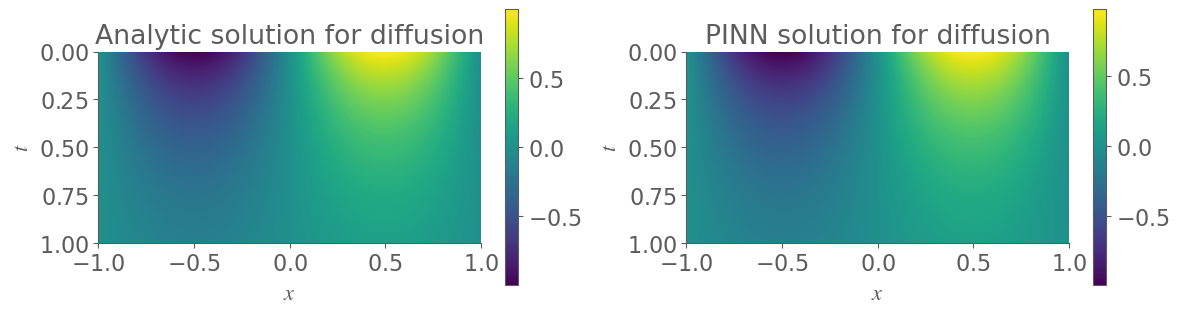

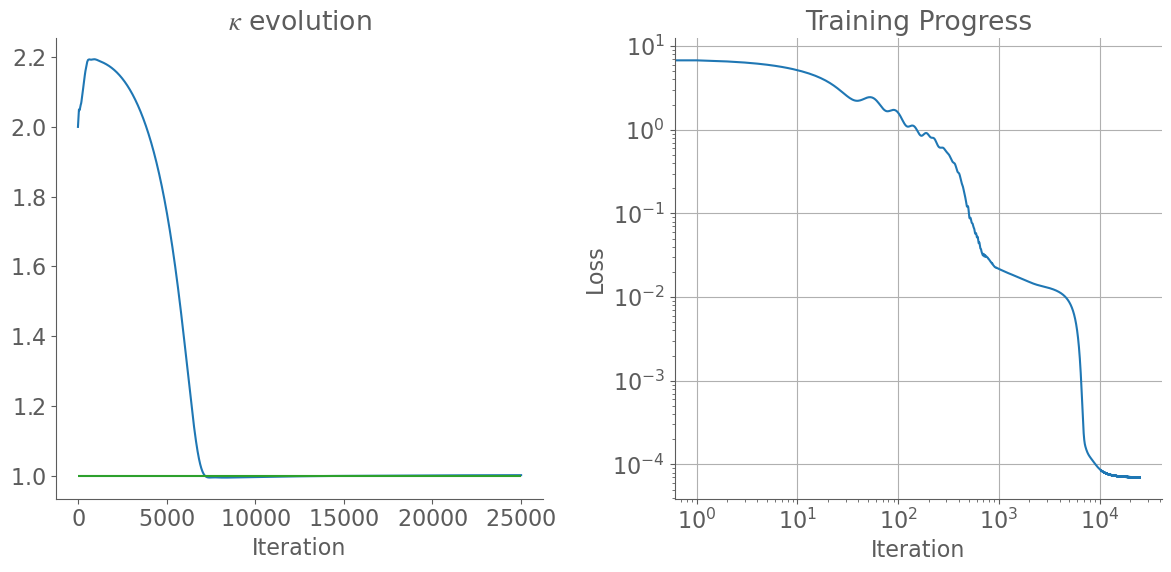

In [12]:
dom_samples = 100

# Dominio espacial
x = np.linspace(-1, 1, dom_samples)
# Dominio temporal
t = np.linspace(0, 2, dom_samples)

# Mallado
X, T = np.meshgrid(x, t)

# Evaluar función en mallado
U = analytic_diffusion(X, T)

X_ten = torch.tensor(X).float().reshape(-1, 1)
T_ten = torch.tensor(T).float().reshape(-1, 1)
domain_ten = torch.cat([T_ten, X_ten], dim = 1)
U_pred = u_pinn(domain_ten).reshape(dom_samples,dom_samples)

U_true = torch.tensor(U).float()
print(f'Relative error: {relative_l2_error(U_pred, U_true)}')

plot_comparison(U, U_pred, loss_values, kappas)

**Ejercicios**:
1. Disminuya y aumente la adivinación inicial del parámetro $\kappa$. Considere que en varias aplicaciones solo se conoce un intervalo de búsqueda para los parámetros desconocidos.
2. Evalúe cómo varía la solución de la PINN aumentando y disminuyendo los pesos `lambdas`.
3. Evalúe cómo varía la solución de la PINN aumentando y disminuyendo la tasa de aprendizaje y el número de iteraciones de entrenamiento.
4. Cambie el número de capas ocultas, neuronas y funciones de activación del modelo de NN.
